In [2]:
### Import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats
from scipy.stats import norm
from IPython.display import Image
import pandas as pd

In [ ]:
### Read Woek Frame files and get their data information(Time)
workframe_list = []
imagedata_list = []
header_list = []
Time_list = []
filenames = []

for i in range(561):
    filename = f'GPX_dump/YEAHSCIENCE_corrected.00000{str(i).zfill(3)}.new'
    filenames.append(filename)
    workframe = fits.open(filename)
    workframe_list.append(workframe)
    imagedata = workframe[0].data
    imagedata_list.append(imagedata)
    header = workframe[0].header
    header_list.append(header)
    Time = workframe[0].header.get('TIME-OBS', -1)
    Time_list.append(Time)

In [ ]:
### Save to CSV Files

# Create a DataFrame
df = pd.DataFrame({
    'Filename': [f'YEAHSCIENCE_corrected.00000{str(i).zfill(3)}.new' for i in range(561)],
    'Time-OBS': Time_list
})

# Save to CSV
df.to_csv('output.csv', index=False)

# Save to Excel
# df.to_excel('output.xlsx', index=False)

In [ ]:
def ra_dec_to_deg(ra_hms, dec_dms):
    # Parse RA
    ra_h, ra_m, ra_s = map(float, ra_hms.split(':'))
    ra_deg = (ra_h + ra_m/60 + ra_s/3600) * 15

    # Parse Dec
    sign = -1 if dec_dms[0] == '-' else 1
    dec_deg, dec_m, dec_s = map(float, dec_dms[1:].split(':'))
    dec_deg = sign * (dec_deg + dec_m/60 + dec_s/3600)

    return ra_deg, dec_deg

### GPX-1 Coordinates
ra_hms = "02:33:28.61"
dec_dms = "+56:01:32.5"
ra_deg, dec_deg = ra_dec_to_deg(ra_hms, dec_dms)
print(f"Target RA in degrees: {ra_deg}")
print(f"Target Dec in degrees: {dec_deg}")
R_ra_hms = "02:33:24.49"
R_dec_dms = "+56:01:06.5"
R_ra_deg, R_dec_deg = ra_dec_to_deg(R_ra_hms, R_dec_dms)
print(f"Reference RA in degrees: {R_ra_deg}")
print(f"Reference Dec in degrees: {R_dec_deg}")

In [3]:
import glob
import pandas as pd

### Define catalog file Column Information
column_names = [
    "NUMBER", "X_IMAGE", "Y_IMAGE", "ALPHA_J2000", "DELTA_J2000", "FLUX_APER",
    "FLUXERR_APER", "FLUX_RADIUS", "FWHM_IMAGE", "BACKGROUND", "THRESHOLD",
    "FLUX_MAX", "ISOAREA_IMAGE", "A_IMAGE", "B_IMAGE", "THETA_IMAGE", "FLAGS"
]

### Target Coordinate
target_ra = 38.3692083
target_dec = 56.0256944 

# Use glob to get all .cat files in the folder
cat_files = glob.glob("GPX_CAT/*.new.cat")

# Loop through each file and apply the operations
for file in cat_files:
    # Read the file
    data = pd.read_csv(file, sep="\s+", comment='#', names=column_names)
    
    ### Calculate the distance between each star and the target star
    data['DISTANCE'] = ((data['ALPHA_J2000'] - target_ra)**2 + (data['DELTA_J2000'] - target_dec)**2)**0.5
    
    ### Find the star with the smallest distance to the target
    target_star = data[data['DISTANCE'] == data['DISTANCE'].min()]
    
    print(f"File: {file}")
    print(target_star[['NUMBER','ALPHA_J2000','DELTA_J2000','FLUX_APER', 'FLUXERR_APER', 'FLUX_RADIUS', 'FLUX_MAX']])
    print("--------------------------------------------------")

File: GPX_CAT\YEAHSCIENCE_corrected.00000000.new.cat
     NUMBER  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  FLUX_RADIUS  \
598     599    38.369232    56.025532   33994.68      219.5824        1.889   

     FLUX_MAX  
598  2390.973  
--------------------------------------------------
File: GPX_CAT\YEAHSCIENCE_corrected.00000001.new.cat
     NUMBER  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  FLUX_RADIUS  \
585     586    38.369316    56.025752   33990.62      219.9676         1.93   

     FLUX_MAX  
585  2519.346  
--------------------------------------------------
File: GPX_CAT\YEAHSCIENCE_corrected.00000002.new.cat
     NUMBER  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  FLUX_RADIUS  \
573     574    38.369262    56.025754    33151.4      218.0309        1.963   

     FLUX_MAX  
573  2184.315  
--------------------------------------------------
File: GPX_CAT\YEAHSCIENCE_corrected.00000003.new.cat
     NUMBER  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER

## Reference Stars
In this section we are trying to find 10 reference stars based on the flux of our target star.

In [4]:
import glob
import pandas as pd
cat_files = glob.glob("GPX_CAT/*.new.cat")

# Dictionary to keep track of star frequencies
star_frequencies = {}

# Flux tolerance
flux_tolerance = 0.30

# Coordinate tolerance (small value to account for slight variations in star positions across images)
coord_tolerance = 0.001

for file in cat_files:
    data = pd.read_csv(file, sep="\s+", comment='#', names=column_names)
    
    # Calculate the distance to the target for each star
    data['DISTANCE'] = ((data['ALPHA_J2000'] - target_ra)**2 + (data['DELTA_J2000'] - target_dec)**2)**0.5
    
    target_star_flux = data[data['DISTANCE'] == data['DISTANCE'].min()]['FLUX_APER'].values[0]
    
    similar_flux_stars = data[(data['FLUX_APER'] >= (1 - flux_tolerance) * target_star_flux) &
                              (data['FLUX_APER'] <= (1 + flux_tolerance) * target_star_flux)]
    
    for _, star in similar_flux_stars.iterrows():
        star_coords = (star['ALPHA_J2000'], star['DELTA_J2000'])
        
        # Exclude the target star
        if abs(star_coords[0] - target_ra) < coord_tolerance and abs(star_coords[1] - target_dec) < coord_tolerance:
            continue
        
        # Check for stars with similar coordinates in the dictionary
        found = False
        for known_coords in star_frequencies.keys():
            if abs(star_coords[0] - known_coords[0]) < coord_tolerance and abs(star_coords[1] - known_coords[1]) < coord_tolerance:
                star_frequencies[known_coords]['count'] += 1
                star_frequencies[known_coords]['files'].append(file)
                found = True
                break
        
        if not found:
            star_frequencies[star_coords] = {'count': 1, 'files': [file]}

sorted_stars = sorted(star_frequencies.items(), key=lambda x: x[1]['count'], reverse=True)

top_10_stars = sorted_stars[:10]

print("Top 10 reference stars:")
for coords, data in top_10_stars:
    missing_files = set(cat_files) - set(data['files'])
    print(f"Coordinates (RA, DEC): {coords}, Frequency: {data['count']}")
    print(f"Missing in files: {', '.join(missing_files)}")



Top 10 reference stars:
Coordinates (RA, DEC): (38.1483286, 55.8588195), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.1048558, 55.8363162), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.2974873, 56.0019077), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.2802016, 56.0293043), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.007821, 55.8885482), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.1261215, 55.9860924), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.2374013, 56.0678863), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (37.9722576, 55.8972717), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (38.1333489, 56.0756301), Frequency: 521
Missing in files: 
Coordinates (RA, DEC): (37.9973365, 55.9908815), Frequency: 521
Missing in files: 


In [29]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

### Define catalog file Column Information
column_names = [
    "NUMBER", "X_IMAGE", "Y_IMAGE", "ALPHA_J2000", "DELTA_J2000", "FLUX_APER",
    "FLUXERR_APER", "FLUX_RADIUS", "FWHM_IMAGE", "BACKGROUND", "THRESHOLD",
    "FLUX_MAX", "ISOAREA_IMAGE", "A_IMAGE", "B_IMAGE", "THETA_IMAGE", "FLAGS"
]

### Target Coordinate
target_ra = 38.3692083
target_dec = 56.0256944 

# Use glob to get all .cat files in the folder
cat_files = glob.glob("GPX_CAT/*.new.cat")

# Dictionary to store flux and error bar values for each reference star
flux_data = {f"Star_{i}": [] for i in range(1, 11)}
flux_error_data = {f"Star_{i}": [] for i in range(1, 11)}
file_names = []
times = []

# Add Target star into dictionary
flux_data['target_star'] = []
flux_error_data['target_star'] = []

coord_tolerance = 0.001

time_df = pd.read_csv("Name_Time.csv")


for file in cat_files:
    # Extract the filename without path and extension
    filename = file.split("/")[-1].replace(".cat", "").replace("GPX_CAT\\","")
    file_names.append(filename)

    time_obs = time_df[time_df['Filename'] == filename]['Time-OBS'].values[0]
    times.append(time_obs)
    
    data = pd.read_csv(file, sep="\s+", comment='#', names=column_names)
    
    # For each reference star, extract its flux and error bar values
    for idx, (coords, _) in enumerate(top_10_stars):
        star = data[(abs(data['ALPHA_J2000'] - coords[0]) < coord_tolerance) & 
                    (abs(data['DELTA_J2000'] - coords[1]) < coord_tolerance)]
        
        if not star.empty:
            flux_data[f"Star_{idx+1}"].append(star['FLUX_APER'].values[0])
            flux_error_data[f"Star_{idx+1}"].append(star['FLUXERR_APER'].values[0])
        else:
            flux_data[f"Star_{idx+1}"].append(None)
            flux_error_data[f"Star_{idx+1}"].append(None)
    
    target_star = data[(abs(data['ALPHA_J2000'] - target_ra) < coord_tolerance) & 
                       (abs(data['DELTA_J2000'] - target_dec) < coord_tolerance)]
    if not target_star.empty:
        flux_data['target_star'].append(target_star['FLUX_APER'].values[0])
        flux_error_data['target_star'].append(target_star['FLUXERR_APER'].values[0])
    else:
        flux_data['target_star'].append(None)
        flux_error_data['target_star'].append(None)

# Displaying the flux and error bar values for each reference star for the first few files
print("Flux and Error Bar values for the first few files:")
for i in range(min(5, len(file_names))):
    print(f"\nFilename: {file_names[i]}, Time: {times[i]}")
    print(f"Target Star - Flux: {flux_data['target_star'][i]}, Error Bar: {flux_error_data['target_star'][i]}")
    for idx in range(1, 11):
        print(f"Star_{idx} - Flux: {flux_data[f'Star_{idx}'][i]}, Error Bar: {flux_error_data[f'Star_{idx}'][i]}")

Flux and Error Bar values for the first few files:

Filename: YEAHSCIENCE_corrected.00000000.new, Time: 01:43:57.177
Target Star - Flux: 33994.68, Error Bar: 219.5824
Star_1 - Flux: 33009.5, Error Bar: 218.4297
Star_2 - Flux: 28901.04, Error Bar: 213.8468
Star_3 - Flux: 36893.68, Error Bar: 222.644
Star_4 - Flux: 27203.83, Error Bar: 211.9117
Star_5 - Flux: 41022.68, Error Bar: 227.1594
Star_6 - Flux: 29873.78, Error Bar: 214.886
Star_7 - Flux: 27374.7, Error Bar: 212.1073
Star_8 - Flux: 26492.18, Error Bar: 211.095
Star_9 - Flux: 27219.57, Error Bar: 211.9926
Star_10 - Flux: 34543.83, Error Bar: 220.2491

Filename: YEAHSCIENCE_corrected.00000001.new, Time: 01:44:26.982
Target Star - Flux: 33990.62, Error Bar: 219.9676
Star_1 - Flux: 33543.37, Error Bar: 219.5347
Star_2 - Flux: 28992.38, Error Bar: 214.3502
Star_3 - Flux: 37157.24, Error Bar: 223.5245
Star_4 - Flux: 27391.45, Error Bar: 212.719
Star_5 - Flux: 40818.93, Error Bar: 227.4069
Star_6 - Flux: 30456.15, Error Bar: 216.0635
St

In [1]:
plt.figure(figsize=(8, 4))

normalized_flux_data = {f"Star_{i}": [] for i in range(1, 11)}
normalized_flux_error_data = {f"Star_{i}": [] for i in range(1, 11)}

for idx in range(1, 11):
    # Calculate average flux for the current star
    valid_fluxes = [flux for flux in flux_data[f"Star_{idx}"] if flux is not None]
    average_flux = sum(valid_fluxes) / len(valid_fluxes)
    
    # Normalize the flux and error values
    normalized_fluxes = [flux/average_flux if flux is not None else None for flux in flux_data[f"Star_{idx}"]]
    normalized_flux_errors = [error/average_flux if error is not None else None for error in flux_error_data[f"Star_{idx}"]]
    
    normalized_flux_data[f"Star_{idx}"] = normalized_fluxes
    normalized_flux_error_data[f"Star_{idx}"] = normalized_flux_errors



for idx in range(1, 11):
    valid_mask = [val is not None for val in normalized_flux_data[f"Star_{idx}"]]
    
    valid_times = [time for i, time in enumerate(times) if valid_mask[i]]
    valid_normalized_flux = [flux for flux in normalized_flux_data[f"Star_{idx}"] if flux is not None]
    valid_normalized_flux_error = [error for error in normalized_flux_error_data[f"Star_{idx}"] if error is not None]

    sorted_indices = sorted(range(len(valid_times)), key=lambda k: valid_times[k])
    valid_times = [valid_times[i] for i in sorted_indices]
    valid_normalized_flux = [valid_normalized_flux[i] for i in sorted_indices]
    valid_normalized_flux_error = [valid_normalized_flux_error[i] for i in sorted_indices]
    
    
    plt.errorbar(valid_times, valid_normalized_flux, yerr=valid_normalized_flux_error, fmt='o', markersize=1.5, label=f"Star_{idx}", capsize=3)

# Set custom tick locations and labels for the x-axis
n = 20  # Display every 50th time value
plt.xticks(valid_times[::n], rotation=45)

plt.xlabel("Observation Time (UTC-0)",size=15)
plt.ylabel("Normalized Flux",size=15)
plt.title("Normalized Flux of Reference Stars Over Time",fontname="Times New Roman", size=20,fontweight="bold")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

## Calibrate Target Star

In [30]:
reformatted_data = []
for idx, time in enumerate(times):
    row_data = {'Time': time}
    for j in range(1, 11):
        star_suffix = f"_Star_{j}"  # e.g., _Star_1, _Star_2, ...
        row_data[f"Flux{star_suffix}"] = flux_data[f"Star_{j}"][idx]
        row_data[f"Flux_Error{star_suffix}"] = flux_error_data[f"Star_{j}"][idx]

    reformatted_data.append(row_data)

df_reformatted = pd.DataFrame(reformatted_data)

# Calculate background bias correction
num_stars = 10  # Number of reference stars
mu_ref_list = []
sigma_ref_list = []
r_list = []
r_error_list = []

for index, row in df_reformatted.iterrows():
    numerator = 0
    denominator = 0
    for j in range(1, num_stars + 1):
        flux_ref = row[f'Flux_Star_{j}']
        sigma_ref = row[f'Flux_Error_Star_{j}']

        numerator += flux_ref / (sigma_ref**2)
        denominator += 1 / (sigma_ref**2)

    mu_ref = numerator / denominator
    sigma_ref = 1 / (denominator**0.5)

    # Calculate the ratio and its error
    r = flux_data['target_star'][index] / mu_ref
    r_error = r * ((flux_error_data['target_star'][index] / flux_data['target_star'][index])**2 + (sigma_ref/mu_ref)**2)**0.5

    # Append to lists
    mu_ref_list.append(mu_ref)
    sigma_ref_list.append(sigma_ref)
    r_list.append(r)
    r_error_list.append(r_error)

# Add results to the dataframe
df_reformatted['mu_ref'] = mu_ref_list
df_reformatted['sigma_ref'] = sigma_ref_list
df_reformatted['r'] = r_list
df_reformatted['r_error'] = r_error_list

output_file = "results.xlsx"
df_reformatted[['Time', 'mu_ref', 'sigma_ref', 'r', 'r_error']].to_excel(output_file, index=False)

print(f"Results saved to {output_file}")

print(df_reformatted[['Time', 'mu_ref', 'sigma_ref', 'r', 'r_error']])

Results saved to results.xlsx
             Time        mu_ref  sigma_ref         r   r_error
0    01:43:57.177  31035.611764  68.384421  1.095344  0.007475
1    01:44:26.982  31269.056351  68.609510  1.087037  0.007428
2    01:44:56.728  31214.562254  68.278607  1.062049  0.007361
3    01:45:26.487  31076.893014  68.296520  1.077156  0.007425
4    01:45:56.245  31149.496132  68.389098  1.078766  0.007419
..            ...           ...        ...       ...       ...
516  06:15:37.778  15961.981639  54.844619  1.079250  0.011587
517  06:16:07.529  15983.462965  54.897051  1.073778  0.011567
518  06:16:37.284  15951.152121  54.874031  1.081889  0.011609
519  06:17:07.033  15743.864617  54.813608  1.086620  0.011756
520  06:17:36.761  15655.432823  54.600186  1.099156  0.011808

[521 rows x 5 columns]


## Plot Lightcurve of Target Star

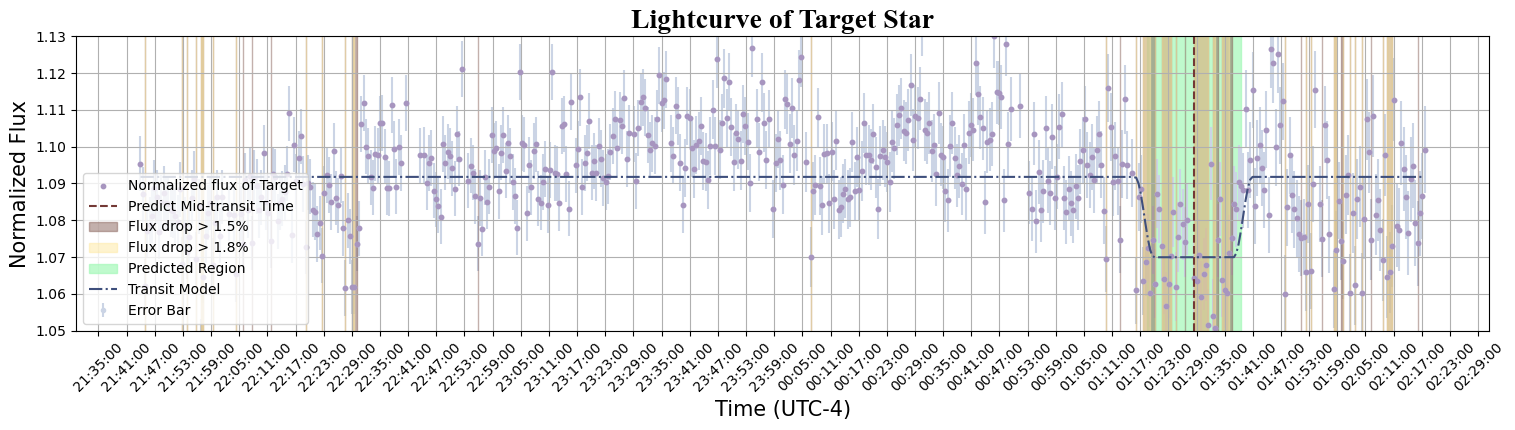

In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import numpy as np

# Convert the 'Time' column to datetime format
if df_reformatted['Time'].dtype == object:
    df_reformatted['Time'] = pd.to_datetime(df_reformatted['Time'], format='%H:%M:%S.%f')

if 'Time_Adjusted' not in df_reformatted.columns:
    df_reformatted['Time'] = df_reformatted['Time'] - pd.Timedelta(hours=4)
    df_reformatted['Time_Adjusted'] = True

# Calculate the average reformatted flux of the target

mid_transit_time = pd.to_datetime("01:28:24", format='%H:%M:%S')
transit_depth = 0.02  # 20% drop in flux
transit_duration = timedelta(minutes=25)  # Replace with your actual duration
ingress_egress_duration = timedelta(minutes=4)  # Replace with your actual duration

start_time = pd.to_datetime("00:00:00", format='%H:%M:%S')
start_predict_time = pd.to_datetime("01:18:24", format='%H:%M:%S')
end_predict_time = pd.to_datetime("01:38:24", format='%H:%M:%S')
df_filtered = df_reformatted[df_reformatted['Time'] >= start_time]


total_duration_days = transit_duration.total_seconds() / 86400.0
ingress_egress_duration_days = ingress_egress_duration.total_seconds() / 86400.0



average_flux = df_reformatted['r'].mean()


### Draw fit model
# times = mdates.date2num(df_reformatted['Time'])  # Convert to matplotlib date format
# model_flux = transit_model(times, mdates.date2num(mid_transit_time), transit_depth, transit_duration / timedelta(days=1), ingress_egress_duration / timedelta(days=1), average_flux)

# Determine the threshold for 1% 1.5% drop
threshold = average_flux * 0.985
threshold_2 = average_flux * 0.983
# Create a mask for the intervals where the flux drops by 1% of the average
mask = df_reformatted['r'] < threshold
mask_2 = df_reformatted['r'] < threshold_2



plt.figure(figsize=(15, 4))



### For Specific Data
# plt.errorbar(df_filtered['Time'], df_filtered['r'], yerr=df_filtered['r_error'], fmt='o', color='#cbd4e5', markersize=3, zorder=1, label='Error Bar')
# plt.scatter(df_filtered['Time'], df_filtered['r'], color='#a795bf', zorder=2, s=10, label='Normalized flux of Target')
# plt.fill_between(df_filtered['Time'], 0, df_filtered['r'].max()+0.02, where=(df_filtered['r'] < threshold), color='#88635a', alpha=0.5, label='Flux drop > 1.5%',zorder=2)
# plt.fill_between(df_filtered['Time'], 0, df_filtered['r'].max()+0.02, where=(df_filtered['r'] < threshold_2), color='#fee9a1', alpha=0.5, label='Flux drop > 1.8%',zorder=3)

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def transit_model(time, mid_transit, depth, total_duration_days, ingress_egress_duration_days, average_flux):

    # Calculate the start and end times of ingress and egress
    ingress_start = mid_transit - total_duration_days / 2
    egress_end = mid_transit + total_duration_days / 2
    ingress_end = ingress_start + ingress_egress_duration_days
    egress_start = egress_end - ingress_egress_duration_days
    
    # Initialize the model flux to be all ones (no transit)
    model_flux = np.full_like(time, average_flux, dtype=float)
    
    # During ingress and egress, use a cosine function to smooth the transition
    ingress_phase = (time >= ingress_start) & (time <= ingress_end)
    egress_phase = (time >= egress_start) & (time <= egress_end)
    
    # Apply a cosine function to ingress and egress phases
    model_flux[ingress_phase] = average_flux - depth * average_flux * (1 - np.cos(np.pi * (time[ingress_phase] - ingress_start) / ingress_egress_duration_days)) / 2
    model_flux[egress_phase] = average_flux - depth * average_flux * (1 - np.cos(np.pi * (egress_end - time[egress_phase]) / ingress_egress_duration_days)) / 2
    
    # During full transit, the flux is constant at (1 - depth) * average_flux
    full_transit = (time > ingress_end) & (time < egress_start)
    model_flux[full_transit] = average_flux - depth * average_flux

    return model_flux
    

model_flux = transit_model(
    times,
    mdates.date2num(mid_transit_time),
    transit_depth,
    total_duration_days, 
    ingress_egress_duration_days,
    average_flux
)

#times = mdates.date2num(df_filtered['Time'])  # Convert to matplotlib date format
times = mdates.date2num(df_reformatted['Time'])
model_flux = transit_model(times, mdates.date2num(mid_transit_time), transit_depth, transit_duration / timedelta(days=1), ingress_egress_duration / timedelta(days=1), average_flux)
#plt.plot(df_filtered['Time'], model_flux, color='#3e4f7c', linestyle='-.', zorder=4, label='Transit Model')

# ### For Whole Data
plt.errorbar(df_reformatted['Time'], df_reformatted['r'], yerr=df_reformatted['r_error'], fmt='o', color='#cbd4e5', markersize=3, zorder=1, label='Error Bar')
plt.scatter(df_reformatted['Time'], df_reformatted['r'], color='#a795bf',zorder=2, s =10, label='Normalized flux of Target')
plt.axvline(pd.to_datetime("01:28:24", format='%H:%M:%S'), color='#733935', linestyle='--', label='Predict Mid-transit Time')
#plt.axhline(average_flux, color='blue', linestyle='--', label='Average Flux' )
plt.fill_between(df_reformatted['Time'], 0, df_reformatted['r'].max(), where=mask, color='#88635a', alpha=0.5, label='Flux drop > 1.5%')
plt.fill_between(df_reformatted['Time'], 0, df_reformatted['r'].max(), where=mask_2, color='#fee9a1', alpha=0.5, label='Flux drop > 1.8%')
plt.fill_betweenx([0, df_reformatted['r'].max()], start_predict_time, end_predict_time, color='#a5f9b9', alpha=0.7, label='Predicted Region',zorder=0)
# Plot the transit model
plt.plot(df_reformatted['Time'], model_flux, color='#3e4f7c', linestyle='-.', zorder=4, label='Transit Model')



plt.title('Lightcurve of Target Star', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time (UTC-4)',size=15)
plt.ylabel('Normalized Flux',size=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
# Set the locator for the x-axis to display more time ticks
locator = mdates.MinuteLocator(interval=6)  # This will automatically determine the interval
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(1.05, 1.13)
plt.legend(loc='lower left')
plt.show()

## Specific time region of target

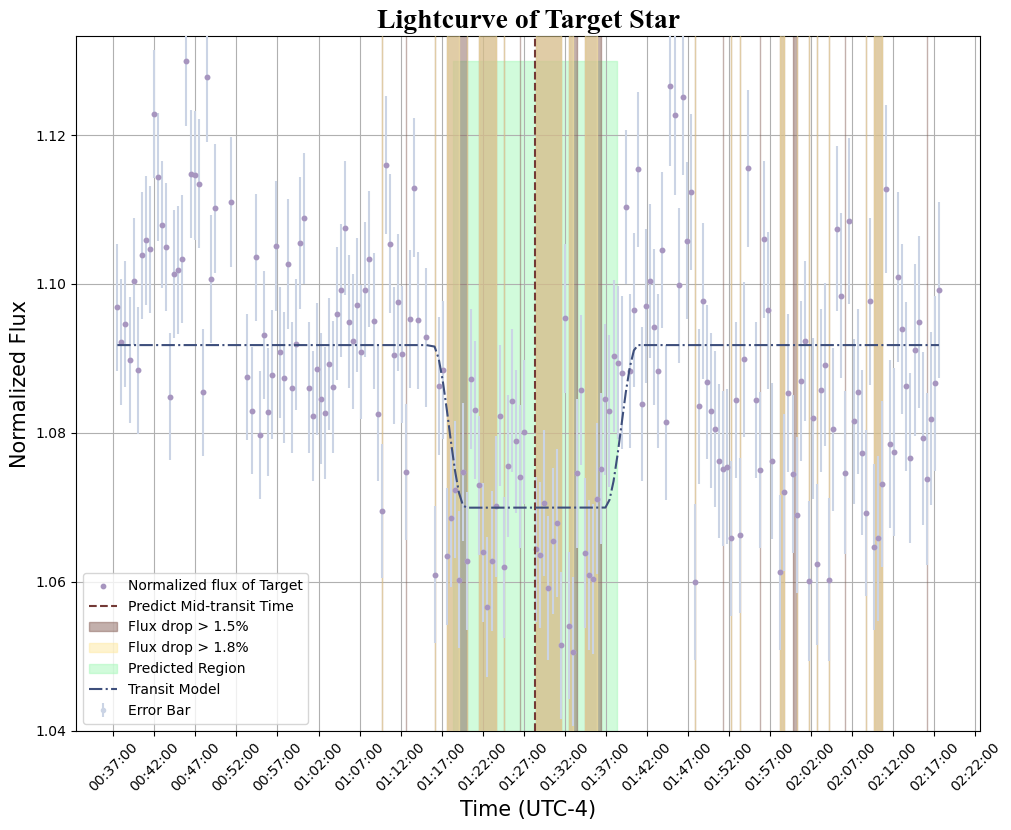

In [77]:
start_time = pd.to_datetime("00:37:00", format='%H:%M:%S')

start_predict_time = pd.to_datetime("01:18:24", format='%H:%M:%S')

end_predict_time = pd.to_datetime("01:38:24", format='%H:%M:%S')

df_filtered = df_reformatted[df_reformatted['Time'] >= start_time]


### Draw fit model
times = mdates.date2num(df_filtered['Time'])  # Convert to matplotlib date format
model_flux = transit_model(times, mdates.date2num(mid_transit_time), transit_depth, transit_duration / timedelta(days=1), ingress_egress_duration / timedelta(days=1), average_flux)

plt.figure(figsize=(10, 8))

plt.errorbar(df_filtered['Time'], df_filtered['r'], yerr=df_filtered['r_error'], fmt='o', color='#cbd4e5', markersize=3, zorder=4, label='Error Bar')
plt.scatter(df_filtered['Time'], df_filtered['r'], color='#a795bf', zorder=5, s=10, label='Normalized flux of Target')

plt.title('Lightcurve of Target Star', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time (UTC-4)',size=15)
plt.ylabel('Normalized Flux',size=15)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Set the locator for the x-axis to display more time ticks
locator = mdates.MinuteLocator(interval=5)  # Adjust the interval as needed
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.axvline(pd.to_datetime("01:28:24", format='%H:%M:%S'), color='#733935', linestyle='--',zorder=6, label='Predict Mid-transit Time')


plt.fill_between(df_filtered['Time'], 0, df_filtered['r'].max()+0.02, where=(df_filtered['r'] < threshold), color='#88635a', alpha=0.5, label='Flux drop > 1.5%',zorder=2)
plt.fill_between(df_filtered['Time'], 0, df_filtered['r'].max()+0.02, where=(df_filtered['r'] < threshold_2), color='#fee9a1', alpha=0.5, label='Flux drop > 1.8%',zorder=3)
plt.fill_betweenx([0, df_filtered['r'].max()], start_predict_time, end_predict_time, color='#a5f9b9', alpha=0.5, label='Predicted Region',zorder=0)

plt.plot(df_filtered['Time'], model_flux, color='#3e4f7c', linestyle='-.', zorder=6, label='Transit Model')


plt.xticks(rotation=45)
plt.ylim(1.04, df_reformatted['r'].max())
plt.legend()
plt.show()

In [37]:
start_visible_time = pd.to_datetime("01:10:24", format='%H:%M:%S')
end_visible_time = pd.to_datetime("01:37:24", format='%H:%M:%S')
filtered_df = df_reformatted[(df_reformatted['Time'] >= start_visible_time) & (df_reformatted['Time'] <= end_visible_time)]
average_flux_filtered = df_filtered['r'].mean()

# Calculate the average flux drop for the filtered rows
average_drop_values = (average_flux - filtered_df['r']) / average_flux
average_drop_values_filtered = (average_flux_filtered-filtered_df['r'])/average_flux_filtered

drop_uncertainties = filtered_df['r_error'] / average_flux

# Compute the average drop
average_drop = average_drop_values.mean()
average_drop_uncertainty = np.sqrt(np.sum(drop_uncertainties**2)) / len(average_drop_values)
a_d_v_f = average_drop_values_filtered.mean()

print(rf"Average drop within the region: {average_drop:.6f} $\pm$ {average_drop_uncertainty:.6f}")
print(rf"Average_flux: {average_flux_filtered:.6f}")
print(rf"Average drop within in region: {a_d_v_f:.6f}")

Average drop within the region: 0.015460 $\pm$ 0.001239
Average_flux: 1.090519
Average drop within in region: 0.014323


In [73]:
from datetime import datetime

# Define the time format
fmt = '%H:%M:%S.%f'

# Parse the two times
t1 = datetime.strptime('05:40:26.127', fmt)
t2 = datetime.strptime('05:13:08.652', fmt)

mid_time = t2+(t1-t2)/2

# Calculate the duration in seconds
duration_seconds = (t1 - t2).total_seconds()

print(f"The duration in seconds is: {duration_seconds} seconds")
print(f"The mid-transit time is: {mid_time.time()}")


The duration in seconds is: 1637.475 seconds
The mid-transit time is: 05:26:47.389500


### Plot Images that contain target to recognize the usability of images.

In [ ]:
import matplotlib.pyplot as pyplot
from astropy.visualization import ZScaleInterval
from collections import namedtuple
from astropy.io import fits
import numpy
from astropy.wcs import WCS
from matplotlib.backends.backend_pdf import PdfPages


### Plot Images that contain target to recognize the usability of images.

Image = namedtuple('Image', ['header', 'data'])

def rend(c): # rend one numpy array into two coordinate lists
  a = []
  b = []
  for c_ in c:
    a.append(c_[0])
    b.append(c_[1])
  return (a, b)

def plot_ij(i, j, image):
  (ny, nx) = image.shape
  pyplot.rcParams.update({'font.size': 5})
  fig = pyplot.figure(figsize=(5,5), dpi=1000)
  ax = fig.add_subplot(111, aspect='equal')
  ax.scatter(i, j, s=50, alpha=0.3, facecolors='red', edgecolors='red')
  ax.set_xlim((0, nx))
  ax.set_ylim((0, ny))
  z = ZScaleInterval()
  (z1, z2) = z.get_limits(image.data)
  ax.imshow(image, cmap='gray_r', vmin=z1, vmax=z2)

def read_image(fh):
  print('reading image...', flush=True)
  hdul = fits.open(fh)
  header = hdul[0].header
  data = hdul[0].data
  return Image(header, data)

with PdfPages('all_plots.pdf') as pdf:
    for filename in filenames:
        image = read_image(filename)
        w = WCS(image.header)
        
        # Process coordinates for the first target
        ra = 38.369208333333326
        dec = 56.02569444444444
        coords_1 = numpy.column_stack((ra, dec))
        pix_coords_1 = w.all_world2pix(coords_1, 1)
        i_1, j_1 = rend(pix_coords_1)
        
        # Print coordinates (if needed)
        print(i_1, j_1)
        
        # Plot the image with the target
        plot_ij(i_1, j_1, image.data)
        
        # Add the filename as a title to the plot
        plt.title(filename)
        
        # Save the current figure to the PDF
        pdf.savefig()
        plt.close()  # Close the current figure to free up memory


## Transit time Prediction

In [ ]:
from datetime import datetime, timedelta

# Function to convert Julian Date to datetime
def jd_to_datetime(jd):
    JD_JAN_1_1970 = 2440587.5 # Julian date at Unix epoch
    seconds_in_day = 86400 # Number of seconds in one day

    # Calculate the number of seconds since the Unix epoch
    seconds = (jd - JD_JAN_1_1970) * seconds_in_day
    # Convert seconds to a datetime object
    return datetime.utcfromtimestamp(seconds)

# Given primary transit Julian Date and orbital period in days
primary_transit_jd = 2458770.23823
orbital_period = 1.744579

# Convert the start and end dates to Julian Dates for comparison
start_date = "2023-09-25"
end_date = "2023-10-05"
start_date_jd = datetime.strptime(start_date, "%Y-%m-%d").timestamp() / 86400.0 + 2440587.5
end_date_jd = datetime.strptime(end_date, "%Y-%m-%d").timestamp() / 86400.0 + 2440587.5

# Initialize a list to hold all transit times within the date range
transit_times = []

# Calculate transit times within the date range
current_transit_jd = primary_transit_jd
while current_transit_jd < end_date_jd:
    if current_transit_jd >= start_date_jd:
        transit_times.append(jd_to_datetime(current_transit_jd))
    current_transit_jd += orbital_period

# Output the transit times
for transit_time in transit_times:
    print(transit_time.strftime("%Y-%m-%d %H:%M:%S"))